In [33]:
#Marine debris training  on Nasa noaa  & unsplash & other randome free images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tqdm import tqdm_notebook
import numpy as np
from tensorflow.keras import preprocessing
from keras.layers import Input, Conv2DTranspose
from tensorflow.keras import utils
import matplotlib.pyplot as plot
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL as image
import PIL
import datetime
import zipfile
import pathlib
import time
import os

In [34]:
ECOBOT_validation_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/ECOBOT dataset/validation')
ECOBOT_train_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/ECOBOT dataset/Training')
image_count = len(list(ECOBOT_train_dir.glob('*/*.jpg')))
print(image_count)

982


In [35]:
#loading images
batch_size = 32
img_h = 256
img_w = 256
train_ds = tf.keras.preprocessing.image_dataset_from_directory(ECOBOT_train_dir,validation_split=0.2
                                                              ,subset="training",seed=123,
                                                             batch_size = batch_size, image_size=(img_h,img_w))

Found 1185 files belonging to 19 classes.
Using 948 files for training.


In [36]:
batch_size = 32
img_h =256
img_w = 256
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(ECOBOT_validation_dir,validation_split=0.2
                                                              ,subset="validation",seed=123,
                                                             batch_size = batch_size, image_size=(img_h,img_w))

Found 850 files belonging to 19 classes.
Using 170 files for validation.


In [37]:
class_names = train_ds.class_names
print(class_names)

['Big objets', 'Cloths', 'Diaster debris', 'Mass of plastic debris', 'Microplastic', 'Plastic and glass bottles', 'Wood', 'cans', 'cigarits', 'coral reef debris', 'fishhing net', 'glass', 'metal', 'paper', 'plastic', 'surface environmental debris', 'susbebded object', 'undefined objects', 'victims of debris']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


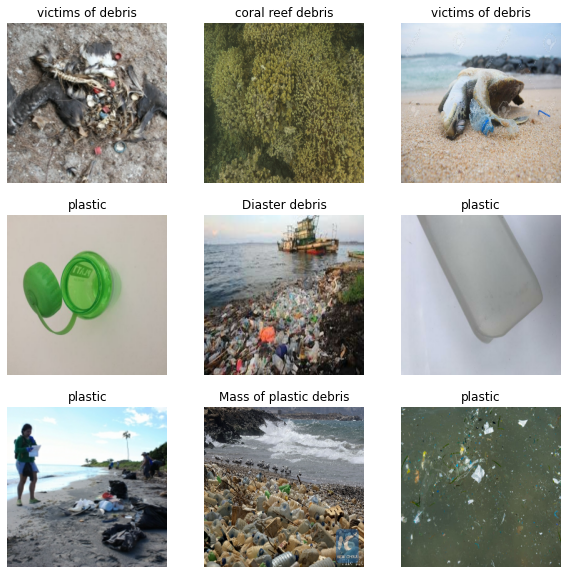

In [38]:
plot.figure(figsize=(10, 10))
for images, labels in train_ds.take(10):
    for i in range(9):
        ax = plot.subplot(3, 3, i + 1)
        plot.imshow(images[i].numpy().astype("uint8"))
        plot.title(class_names[labels[i]])
        plot.axis("off")

In [39]:
#using Xception model for better accuracy
ECOBOT_Base_model =Image_shape = (128,128,3)
ECOBOT_Base_model = tf.keras.applications.MobileNetV2(input_shape=Image_shape, include_top=False, weights="imagenet")
ECOBOT_Base_model.summary()


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [40]:
ECOBOT_Base_model.trainable = False
ECOBOT_Base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(ECOBOT_Base_model.output)

#prediction layer / output layer

Output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

#our model
ECOBOT_model = tf.keras.models.Model(inputs=ECOBOT_Base_model.input, outputs= Output_layer)
ECOBOT_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [42]:
#compilation
ECOBOT_model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.0001),loss = "categorical_crossentropy"
              ,metrics=["accuracy"])
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)


In [43]:
#training the our model
train_generator = data_gen_train.flow_from_directory(ECOBOT_train_dir,
                                                     target_size=(128,128), batch_size=128,
                                                     class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(ECOBOT_validation_dir,
                                                     target_size=(128,128), 
                                                     batch_size=128, class_mode="categorical")
ECOBOT_model.fit(train_generator, epochs=5, validation_data=valid_generator)


Found 1183 images belonging to 19 classes.
Found 849 images belonging to 19 classes.
Epoch 1/5
10/10 [==============================] - 213s 22s/step - loss: 2.5163 - accuracy: 0.8118 - val_loss: 3.0583 - val_accuracy: 0.8713
Epoch 2/5
10/10 [==============================] - 75s 8s/step - loss: 2.0294 - accuracy: 0.8693 - val_loss: 3.2443 - val_accuracy: 0.8841
Epoch 3/5
10/10 [==============================] - 76s 8s/step - loss: 1.7899 - accuracy: 0.8955 - val_loss: 3.4193 - val_accuracy: 0.8880
Epoch 4/5
10/10 [==============================] - 75s 8s/step - loss: 1.6260 - accuracy: 0.9083 - val_loss: 3.5312 - val_accuracy: 0.8901
Epoch 5/5
10/10 [==============================] - 75s 7s/step - loss: 1.5120 - accuracy: 0.9164 - val_loss: 3.6661 - val_accuracy: 0.8918


In [45]:
#Final evaluation
valid_loss, valid_accuracy = ECOBOT_model.evaluate(valid_generator)
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

7/7 [==============================] - 13s 2s/step - loss: 3.6661 - accuracy: 0.8918
Validation accuracy after fine tuning: 0.8917612433433533
